In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd

## Task 1

Extracting EDF parameters from /Users/kris/Desktop/COGS189/COGS189_FinalProject/files/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


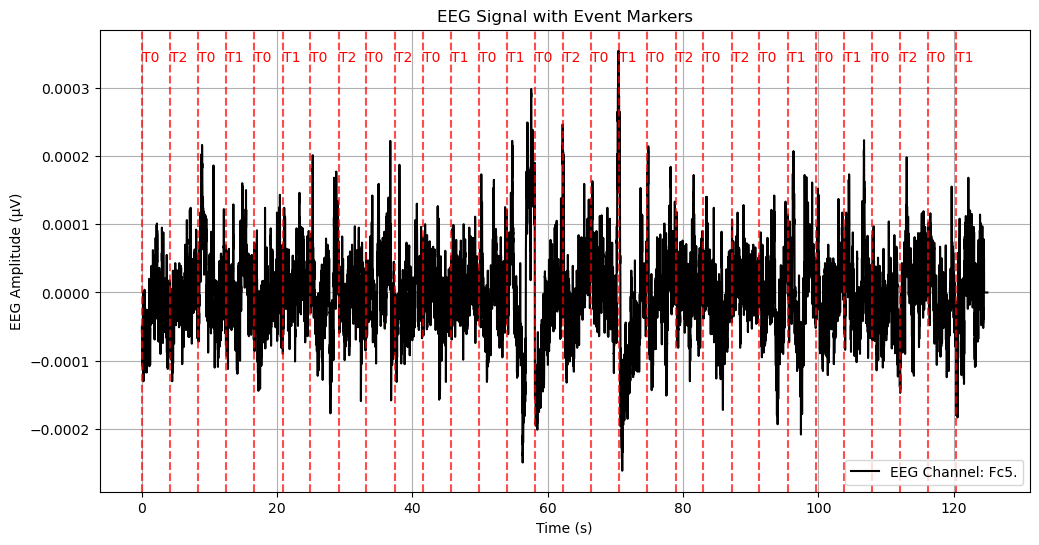

In [7]:
edf_file_path = "./files/S001/S001R03.edf"
event_file_path = "./files/S001/S001R03.edf.event"

raw = mne.io.read_raw_edf(edf_file_path, preload=True)
eeg_data, times = raw[:,:]

event_times = raw.annotations.onset
event_labels = raw.annotations.description

with open(event_file_path, "rb") as f:
    event_data = f.read()

decoded_text = event_data.decode("utf-8", errors="ignore")
event_pattern = re.findall(r'(T[012]) duration: (\d+\.\d+)', decoded_text)
parsed_events = [{"Event": match[0], "Duration (s)": float(match[1])} for match in event_pattern]
df_events = pd.DataFrame(parsed_events)

channel_idx = 0
eeg_signal = eeg_data[channel_idx]

plt.figure(figsize=(12, 6))
plt.plot(times, eeg_signal, label=f"EEG Channel: {raw.ch_names[channel_idx]}", color="black")

for etime, elabel in zip(event_times, event_labels):
    plt.axvline(x=etime, color="red", linestyle="--", alpha=0.7)
    plt.text(etime, np.max(eeg_signal), elabel, color="red", fontsize=10, verticalalignment='top')

plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal with Event Markers")
plt.legend()
plt.grid()

plt.show()


Extracting EDF parameters from /Users/kris/Desktop/COGS189/COGS189_FinalProject/files/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 529 samples (3.306 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


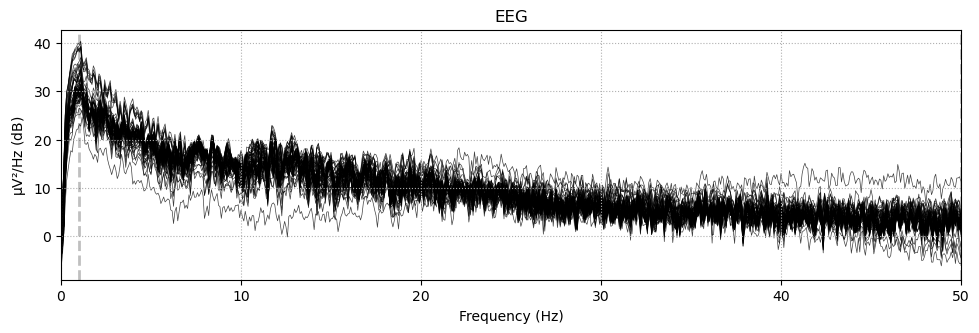

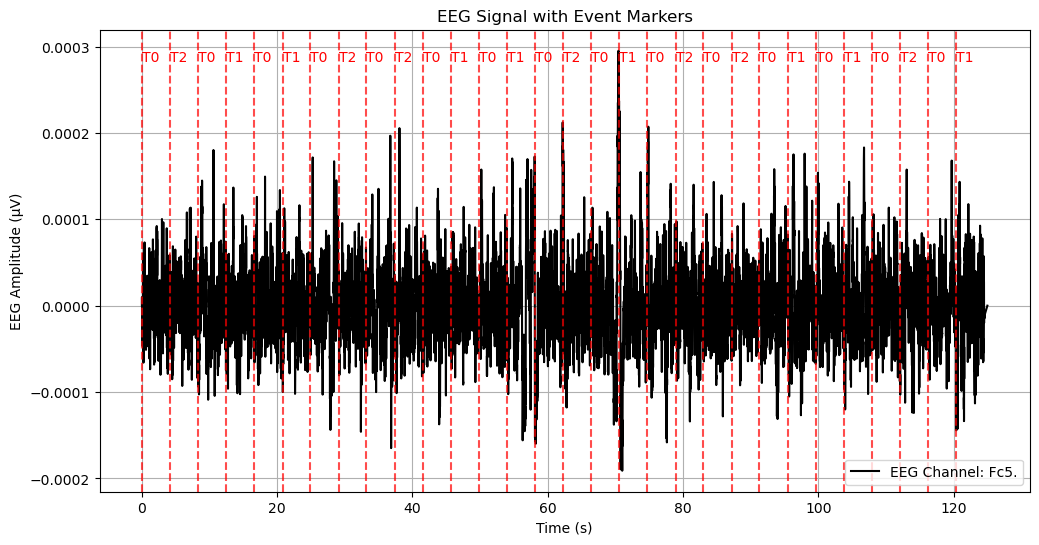

Not setting metadata
30 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)


/var/folders/g7/2jrpz1td1gvfhtddsqp_957c0000gn/T/ipykernel_68583/937168564.py:60: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
/opt/anaconda3/lib/python3.12/site-packages/mne/viz/utils.py:137: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


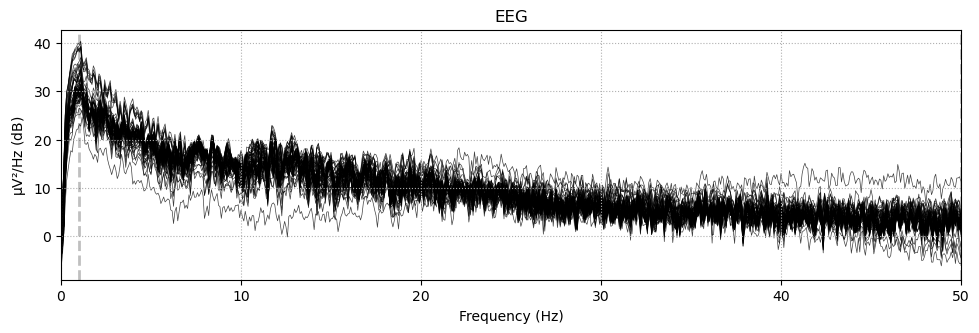

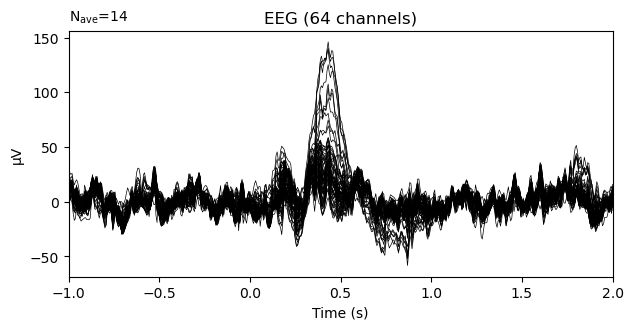

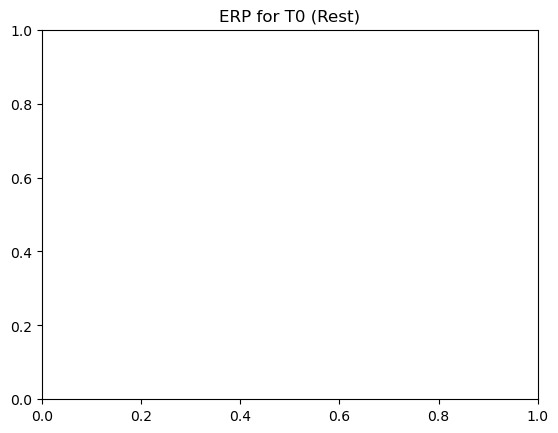

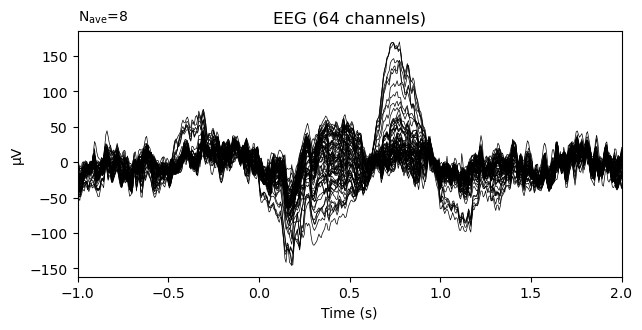

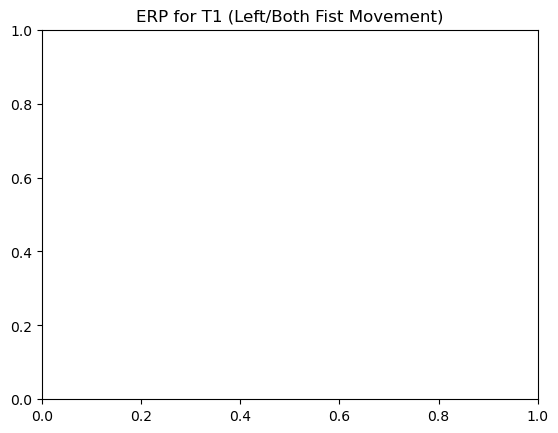

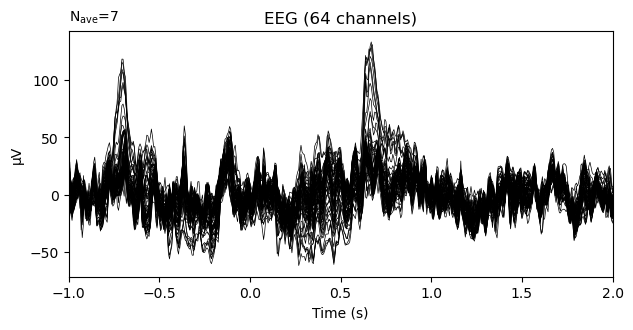

RuntimeError: No digitization points found.

In [16]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

# 文件路径
edf_file_path = "./files/S001/S001R03.edf"
event_file_path = "./files/S001/S001R03.edf.event"

# 读取 EDF 文件
raw = mne.io.read_raw_edf(edf_file_path, preload=True)

# 低频、高频滤波（去伪迹）
raw.filter(1, 50, fir_design='firwin')

# 获取 EEG 数据和时间轴
eeg_data, times = raw[:,:]

# 读取事件信息（从 EDF 注释）
event_times = raw.annotations.onset  # 事件时间戳
event_labels = raw.annotations.description  # 事件标签（T0, T1, T2）

# 解析 .event 文件
with open(event_file_path, "rb") as f:
    event_data = f.read()

# 解析事件数据
decoded_text = event_data.decode("utf-8", errors="ignore")
event_pattern = re.findall(r'(T[012]) duration: (\d+\.\d+)', decoded_text)
parsed_events = [{"Event": match[0], "Duration (s)": float(match[1])} for match in event_pattern]
df_events = pd.DataFrame(parsed_events)

# 选择 EEG 通道
channel_idx = 0  # 选择第一个通道
eeg_signal = eeg_data[channel_idx]

# 1. 绘制 EEG 信号及事件标记
plt.figure(figsize=(12, 6))
plt.plot(times, eeg_signal, label=f"EEG Channel: {raw.ch_names[channel_idx]}", color="black")

for etime, elabel in zip(event_times, event_labels):
    plt.axvline(x=etime, color="red", linestyle="--", alpha=0.7)
    plt.text(etime, np.max(eeg_signal), elabel, color="red", fontsize=10, verticalalignment='top')

plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal with Event Markers")
plt.legend()
plt.grid()
plt.show()

# 2. 提取事件时间窗口（T0, T1, T2）
event_id = {"T0": 1, "T1": 2, "T2": 3}
events = np.array([[int(t * raw.info["sfreq"]), 0, event_id[l]] for t, l in zip(event_times, event_labels)])

epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-1.0, tmax=2.0, baseline=(None, 0), detrend=1)

# 3. 计算功率谱密度（PSD）
raw.plot_psd(fmax=50)

# 4. 计算 ERP（事件相关电位）
evoked_T0 = epochs['T0'].average()
evoked_T1 = epochs['T1'].average()
evoked_T2 = epochs['T2'].average()

fig = evoked_T0.plot()
plt.title("ERP for T0 (Rest)")

fig = evoked_T1.plot()
plt.title("ERP for T1 (Left/Both Fist Movement)")

fig = evoked_T2.plot()
plt.title("ERP for T2 (Right Fist/Both Feet Movement)")

# 5. 绘制 EEG 拓扑图
evoked_T1.plot_topomap(times=np.linspace(0.1, 0.5, 5), ch_type='eeg')

# 6. 计算通道间相干性
from mne.connectivity import spectral_connectivity
con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
    epochs, method='coh', mode='multitaper', sfreq=160, fmin=8, fmax=30, faverage=True
)




## Task 2

Extracting EDF parameters from /Users/kris/Desktop/COGS189/COGS189_FinalProject/files/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


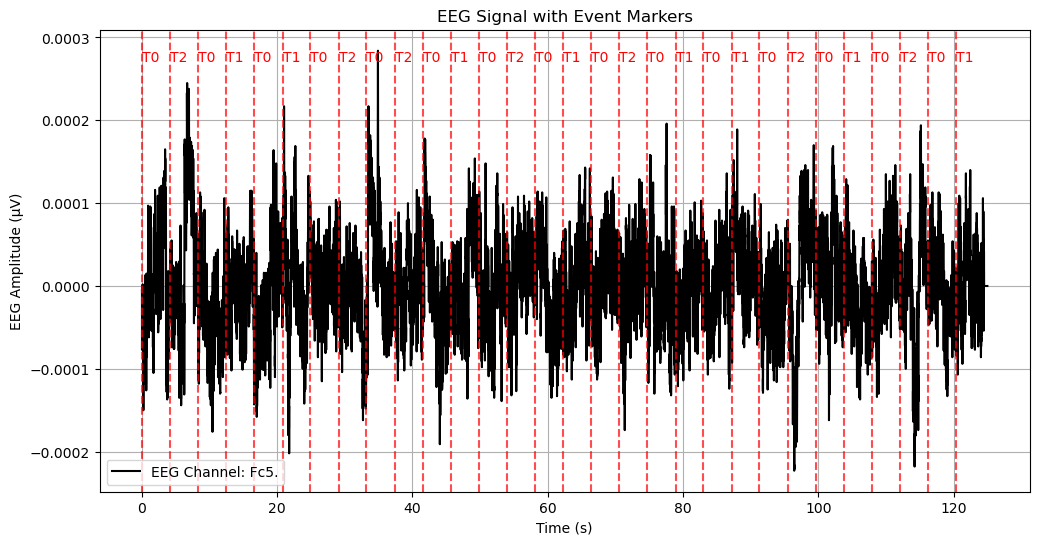

In [3]:
edf_file_path = "./files/S001/S001R04.edf"
event_file_path = "./files/S001/S001R04.edf.event"

raw = mne.io.read_raw_edf(edf_file_path, preload=True)
eeg_data, times = raw[:,:]

event_times = raw.annotations.onset
event_labels = raw.annotations.description

with open(event_file_path, "rb") as f:
    event_data = f.read()

decoded_text = event_data.decode("utf-8", errors="ignore")
event_pattern = re.findall(r'(T[012]) duration: (\d+\.\d+)', decoded_text)
parsed_events = [{"Event": match[0], "Duration (s)": float(match[1])} for match in event_pattern]
df_events = pd.DataFrame(parsed_events)

channel_idx = 0
eeg_signal = eeg_data[channel_idx]

plt.figure(figsize=(12, 6))
plt.plot(times, eeg_signal, label=f"EEG Channel: {raw.ch_names[channel_idx]}", color="black")

for etime, elabel in zip(event_times, event_labels):
    plt.axvline(x=etime, color="red", linestyle="--", alpha=0.7)
    plt.text(etime, np.max(eeg_signal), elabel, color="red", fontsize=10, verticalalignment='top')

plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal with Event Markers")
plt.legend()
plt.grid()

plt.show()


## Task 3

Extracting EDF parameters from /Users/kris/Desktop/COGS189/COGS189_FinalProject/files/S001/S001R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


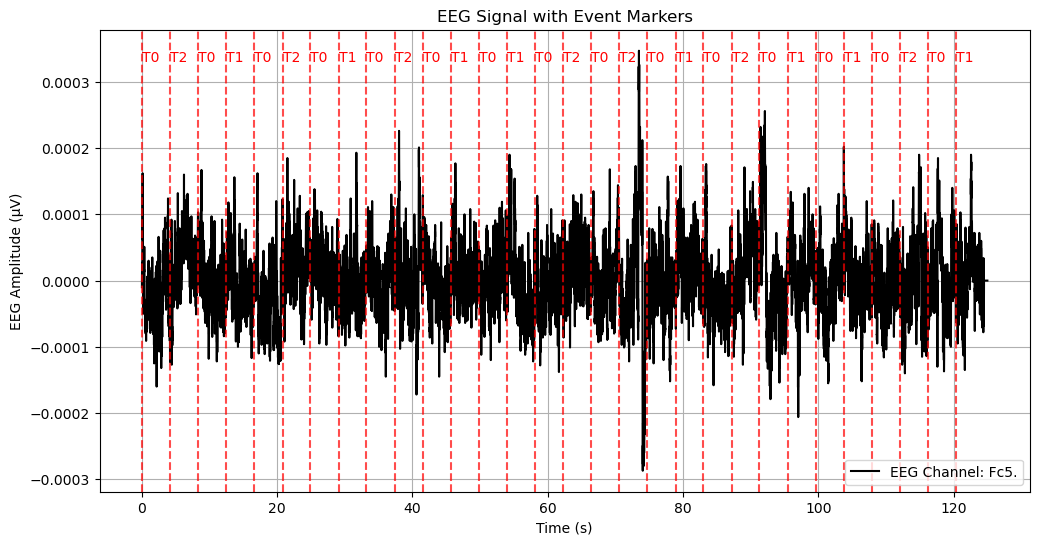

In [4]:
edf_file_path = "./files/S001/S001R05.edf"
event_file_path = "./files/S001/S001R05.edf.event"

raw = mne.io.read_raw_edf(edf_file_path, preload=True)
eeg_data, times = raw[:,:]

event_times = raw.annotations.onset
event_labels = raw.annotations.description

with open(event_file_path, "rb") as f:
    event_data = f.read()

decoded_text = event_data.decode("utf-8", errors="ignore")
event_pattern = re.findall(r'(T[012]) duration: (\d+\.\d+)', decoded_text)
parsed_events = [{"Event": match[0], "Duration (s)": float(match[1])} for match in event_pattern]
df_events = pd.DataFrame(parsed_events)

channel_idx = 0
eeg_signal = eeg_data[channel_idx]

plt.figure(figsize=(12, 6))
plt.plot(times, eeg_signal, label=f"EEG Channel: {raw.ch_names[channel_idx]}", color="black")

for etime, elabel in zip(event_times, event_labels):
    plt.axvline(x=etime, color="red", linestyle="--", alpha=0.7)
    plt.text(etime, np.max(eeg_signal), elabel, color="red", fontsize=10, verticalalignment='top')

plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal with Event Markers")
plt.legend()
plt.grid()

plt.show()


## Task 4

Extracting EDF parameters from /Users/kris/Desktop/COGS189/COGS189_FinalProject/files/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


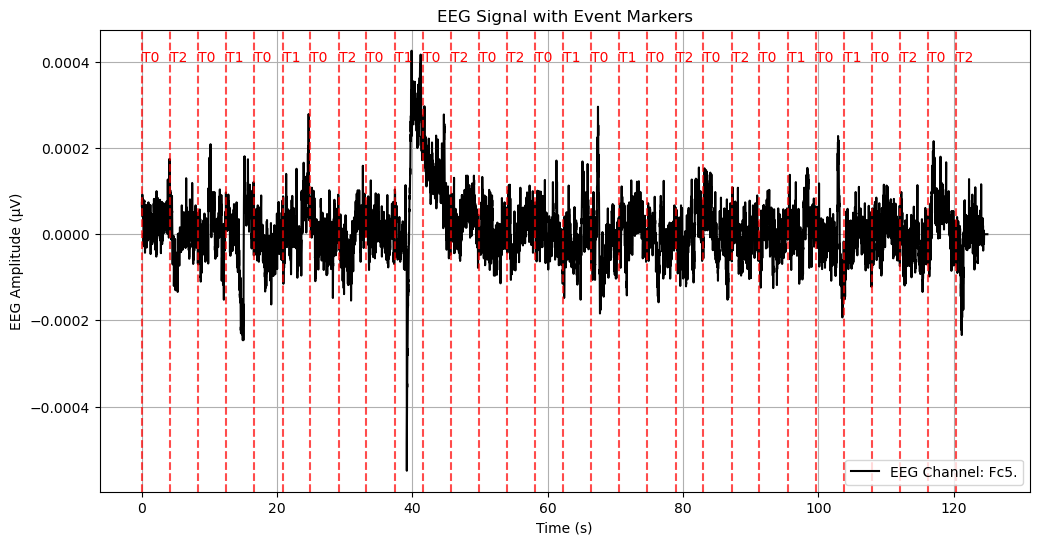

In [5]:
edf_file_path = "./files/S001/S001R06.edf"
event_file_path = "./files/S001/S001R06.edf.event"

raw = mne.io.read_raw_edf(edf_file_path, preload=True)
eeg_data, times = raw[:,:]

event_times = raw.annotations.onset
event_labels = raw.annotations.description

with open(event_file_path, "rb") as f:
    event_data = f.read()

decoded_text = event_data.decode("utf-8", errors="ignore")
event_pattern = re.findall(r'(T[012]) duration: (\d+\.\d+)', decoded_text)
parsed_events = [{"Event": match[0], "Duration (s)": float(match[1])} for match in event_pattern]
df_events = pd.DataFrame(parsed_events)

channel_idx = 0
eeg_signal = eeg_data[channel_idx]

plt.figure(figsize=(12, 6))
plt.plot(times, eeg_signal, label=f"EEG Channel: {raw.ch_names[channel_idx]}", color="black")

for etime, elabel in zip(event_times, event_labels):
    plt.axvline(x=etime, color="red", linestyle="--", alpha=0.7)
    plt.text(etime, np.max(eeg_signal), elabel, color="red", fontsize=10, verticalalignment='top')

plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal with Event Markers")
plt.legend()
plt.grid()

plt.show()
